This notebook is by Anastasia Ruzmaikina.

In this notebook we train a LSTM neural network to predict the log returns of the price of the stock given the history of its log returns.

The log return of the stock is defined as
$$u_t = 𝑙𝑛(\frac{𝑆_{𝑡+1}}{𝑆_𝑡})$$
 
and is approximately equal to
$$\frac{𝑆_{𝑡+1}−𝑆_𝑡}{𝑆_𝑡}.$$
 
If  $𝑆_𝑡$
  was a Geometric Brownian motion, then
$$\frac{𝑑𝑆_𝑡}{𝑆_𝑡}=\mu 𝑑𝑡+ \sigma 𝑑𝑊_𝑡$$
 
and therefore the log return would be a Gaussian stochastic process.

In real life, we expect
$$u_t = 𝑙𝑛(\frac{𝑆_{𝑡+1}}{𝑆_𝑡})$$
 
to behave as a random process and to be difficult to predict. In the notebook stock_prediction-LSTM-Part1, we showed that the trained LSTM neural network tries to predict the mean value of the process rather than individual fluctuations. This is not surprising: if you trained someone to predict the next roll of a fair dice, the most accurate prediction they could make is to predict the mean. 

In this notebook we define a new process $$x_t = \frac{u_t + u_{t+1} + u_{t+2}}{3}.$$  This is a moving average with the width of the window equal to 3. From the probability standpoint, the process $x_t$ is not very different from $u_t$, because if the standard deviation of $u_t$ is $\sigma$ and assuming that $u_t$ are uncorrelated, we derive the standard deviation of $x_t$ is $\sigma/\sqrt{3}$. So it is reasonable to assume that a trained LSTM neural network would once again try to predict just the mean of the process $x_t$ as it did for the process $u_t$. 

Very surprisingly, it is not the case. When the LSTM neural network is predicting the text data for $x_t$ the predictions are almost perfect! It is possible to achive an even higher accuracy by taking a bigger LSTM and training it for more iterations. 

We think that the reason for very accurate predictions is that if the case of $x_t$ there exist short-range correlations, i.e. $x_t$, $x_{t+1}$ and $x_{t+2}$ are all correlated. The LSTM neural network detects those correlations and therefore "tries" to predict the next step. In the case of $u_t$ it does not detect correlations so it "doesn't try" to predict the next step, settiling instead for predicting the mean.

This result implies that it is possible to make very accurate predictions for any financial product which depends on a three-day average rather than on the price at a particular day.



Firt we import the necessary Python libraries:

In [1]:
#import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore', 'DeprecationWarning: The use of \'dynamic_batch_size\' is deprecated. Use the \'batch_size\' argument instead.')


The dataset is the set of log returns of stock prices for an NYSE stock for the period of 5 years ending on 8/30/23.

The dataset is saved as a 'Stock1.csv' file and we download it into a Pandas Dataframe 'data'.

In [2]:
data = pd.read_csv('Stock1.csv')
data

,log_returns
0,-0.009987
1,0.005408
2,-0.032775
3,-0.013849
4,-0.032129
...,...
1158,-0.039066
1159,0.012543
1160,-0.039570
1161,0.009037


We see that the dataset has 1163 datapoints and we can plot the data.

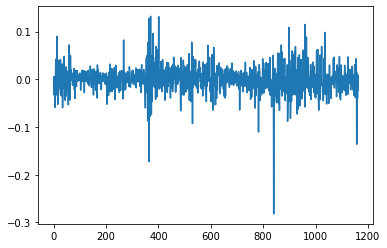

In [3]:
plt.plot(data)


We now construct a new dataset $x_t$ of moving averages with the window size 3. $$x_i = \frac{data(i)+ data({i+1}) + data({i+2})}{3}.$$ We find the langth of the dataset $x_t$ to be 1161 data points and we graph the dataset.

We graph the dataset 'x'.

1161

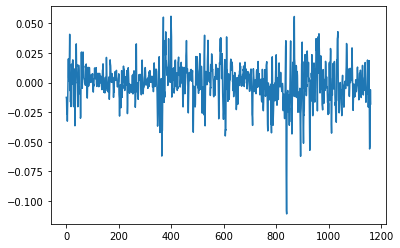

In [4]:
x = []
for i in range(len(data)-2):
    x.append((data.iloc[i]+data.iloc[i+1]+data.iloc[i+2])/3)
plt.plot(x) 

len(x)

We can see that if we plot both the dataset of log returns 'data' and the dataset of moving averages $x$ the graphs are very similar, the only difference seems to be that $x$ (graphed in red) has somewhat smaller volatility than 'data' (graphed in blue).

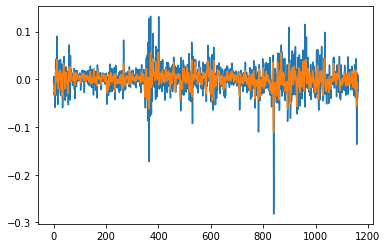

In [5]:
plt.plot(data)
plt.plot(x)


We use the first 1100 datapoints in the dataset 'x' as a training set. We are going to train LSTM neural network on this 'training_set' and use it to predict the 'test_set' of the last 60 datapoints.

In [7]:
#training set
training_set = np.array(x[:1101])
training_set

array([[-0.01245127],
       [-0.01373875],
       [-0.02625089],
       ...,
       [-0.01214088],
       [-0.01161171],
       [-0.01141063]])

We rescale the 'training_set' using the min-max scaler.

In [8]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))

We create the training data structure where the data of the previous 20 timesteps (X_train) are used to predict the next timestep (y_train). (In NLP this is called an n-gram). To see what the new training data looks like, we print out X_train. It is easy to see that X_train consists of 1081 sequences of length 20, where each new sequence is shifted by 1 compared to the previous sequence.

In [9]:
#creating a data structure with 20 timesteps and 1 output
X_train = []
y_train = []
for i in range(20, 1101):
    X_train.append(training_set_scaled[i-20:i, 0])  #column 0
    y_train.append(training_set_scaled[i,0]) #train ith value using i-20:i
X_train, y_train = np.array(X_train), np.array(y_train)  #convert to numpy array
#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)

[[[0.58958068]
  [0.5818633 ]
  [0.50686328]
  ...
  [0.61701154]
  [0.54299703]
  [0.68377208]]

 [[0.5818633 ]
  [0.50686328]
  [0.55940822]
  ...
  [0.54299703]
  [0.68377208]
  [0.75776988]]

 [[0.50686328]
  [0.55940822]
  [0.46933155]
  ...
  [0.68377208]
  [0.75776988]
  [0.72765936]]

 ...

 [[0.60137778]
  [0.59437958]
  [0.63686706]
  ...
  [0.60501153]
  [0.65743721]
  [0.63443946]]

 [[0.59437958]
  [0.63686706]
  [0.72002906]
  ...
  [0.65743721]
  [0.63443946]
  [0.59144119]]

 [[0.63686706]
  [0.72002906]
  [0.73656443]
  ...
  [0.63443946]
  [0.59144119]
  [0.59461316]]]


This verifies that X_train is a single numpy array consisting of 1081 arrays of length 20.

In [11]:
X_train.shape

(1081, 20, 1)

Now we are ready to import all of the necessary Keras libraries and packages.

In [168]:
#import keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

We initialize the recurrent neural network:

In [169]:
#initialize rnn
regressor = Sequential()

We start adding LSTM layers. The size of the layers should be as large as possible, but it makes the neural network significantly slower, so here we use the output size of 500 units. The input size is given by the X_train, the training dataset. The 20% dropout means that approximately 20% of neurons would be randomly dropped out during training. This is done to avoid overfitting the training set, because this results in worse predictions on the test set.

In [170]:
#adding the LSTM layer and some Dropout reguralization (drops unnecessary data)
regressor.add(LSTM(units=500, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) #can overtrain, to avoid this turn off 20% neurons randomly picked

2023-10-01 14:41:30.077920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 14:41:30.085923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 14:41:30.092536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We add another LSTM layer with 500 cells.

In [171]:
#adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units=500, return_sequences = True))
regressor.add(Dropout(0.2))

2023-10-01 14:41:31.343914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 14:41:31.377372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 14:41:31.381044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We add another LSTM layer with 500 cells.

In [172]:
#adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units=500, return_sequences = True))
regressor.add(Dropout(0.2))

2023-10-01 14:41:32.631751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 14:41:32.635171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 14:41:32.638733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We add another LSTM layer with 500 cells.

In [173]:
#adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units=500))
regressor.add(Dropout(0.2))

2023-10-01 14:41:33.931055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 14:41:33.948478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 14:41:33.953323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Finally we add a dense layer, which is a layer where 1 output is connected to all of the 500 inputs. This is the output layer that gives the predicted value $y$.

In [174]:
#adding the output layer
regressor.add(Dense(units = 1))  #dense means 1 output

Now that RNN is contructed, we compile it and require it to minimize the 'mean squred error' loss function for the output $y$ as compared with the training set y_train. The optimizer 'adam' is an extension of stochastic gradient descent algorithm which decides how to update the weights of the neural network during the training process and dynamically computes individual learning rates to create an adaptive learing rate required to navigate the optimization landscape during training.

In [175]:
#compile the rnn
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')  #adam optimized for big data

We finally train the RNN for 500 epochs, meaning the learning algorithm would work through the entire dataset 500 times. One epoch means that the weights of the neurons in the RNN have an opportunity to be updated once.

The number of epochs should be as large as possible, but it slows down the training significantly.

In [176]:
#fit rnn to the training set
regressor.fit(X_train, y_train, epochs = 500, batch_size = 32) 
#number of epochs is how many times we go over our data set, batch size so that data is loaded in batches of 32 lines

Epoch 1/500


2023-10-01 14:41:35.358242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 14:41:35.370388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 14:41:35.375016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 79s 2s/step - loss: 0.5285
Epoch 2/500
34/34 [==============================] - 55s 2s/step - loss: 0.0119
Epoch 3/500
34/34 [==============================] - 53s 2s/step - loss: 0.0111
Epoch 4/500
34/34 [==============================] - 58s 2s/step - loss: 0.0103
Epoch 5/500
34/34 [==============================] - 59s 2s/step - loss: 0.0105
Epoch 6/500
34/34 [==============================] - 53s 2s/step - loss: 0.0101
Epoch 7/500
34/34 [==============================] - 52s 2s/step - loss: 0.0101
Epoch 8/500
34/34 [==============================] - 52s 2s/step - loss: 0.0098
Epoch 9/500
34/34 [==============================] - 52s 2s/step - loss: 0.0100
Epoch 10/500
34/34 [==============================] - 52s 2s/step - loss: 0.0101
Epoch 11/500
34/34 [==============================] - 57s 2s/step - loss: 0.0105
Epoch 12/500
34/34 [==============================] - 57s 2s/step - loss: 0.0101
Epoch 13/500
34/34 [=============================

34/34 [==============================] - 70s 2s/step - loss: 0.0052
Epoch 103/500
34/34 [==============================] - 65s 2s/step - loss: 0.0049
Epoch 104/500
34/34 [==============================] - 83s 2s/step - loss: 0.0050
Epoch 105/500
34/34 [==============================] - 88s 3s/step - loss: 0.0049
Epoch 106/500
34/34 [==============================] - 78s 2s/step - loss: 0.0050
Epoch 107/500
34/34 [==============================] - 56s 2s/step - loss: 0.0050
Epoch 108/500
34/34 [==============================] - 52s 2s/step - loss: 0.0055
Epoch 109/500
34/34 [==============================] - 52s 2s/step - loss: 0.0049
Epoch 110/500
34/34 [==============================] - 51s 2s/step - loss: 0.0048
Epoch 111/500
34/34 [==============================] - 53s 2s/step - loss: 0.0056
Epoch 112/500
34/34 [==============================] - 53s 2s/step - loss: 0.0045
Epoch 113/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049
Epoch 114/500
34/34 [=========

34/34 [==============================] - 54s 2s/step - loss: 0.0048
Epoch 203/500
34/34 [==============================] - 53s 2s/step - loss: 0.0050
Epoch 204/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049
Epoch 205/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049
Epoch 206/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049
Epoch 207/500
34/34 [==============================] - 53s 2s/step - loss: 0.0048
Epoch 208/500
34/34 [==============================] - 53s 2s/step - loss: 0.0047
Epoch 209/500
34/34 [==============================] - 53s 2s/step - loss: 0.0045
Epoch 210/500
34/34 [==============================] - 53s 2s/step - loss: 0.0042
Epoch 211/500
34/34 [==============================] - 53s 2s/step - loss: 0.0045
Epoch 212/500
34/34 [==============================] - 53s 2s/step - loss: 0.0048
Epoch 213/500
34/34 [==============================] - 52s 2s/step - loss: 0.0045
Epoch 214/500
34/34 [=========

34/34 [==============================] - 30s 887ms/step - loss: 0.0029
Epoch 401/500
34/34 [==============================] - 29s 851ms/step - loss: 0.0026
Epoch 402/500
34/34 [==============================] - 30s 894ms/step - loss: 0.0027
Epoch 403/500
34/34 [==============================] - 29s 842ms/step - loss: 0.0027
Epoch 404/500
34/34 [==============================] - 29s 843ms/step - loss: 0.0028
Epoch 405/500
34/34 [==============================] - 29s 852ms/step - loss: 0.0030
Epoch 406/500
34/34 [==============================] - 29s 848ms/step - loss: 0.0029
Epoch 407/500
34/34 [==============================] - 28s 832ms/step - loss: 0.0029
Epoch 408/500
34/34 [==============================] - 29s 836ms/step - loss: 0.0028
Epoch 409/500
34/34 [==============================] - 28s 839ms/step - loss: 0.0025
Epoch 410/500
34/34 [==============================] - 28s 837ms/step - loss: 0.0025
Epoch 411/500
34/34 [==============================] - 28s 823ms/step - loss: 0

We now have a fully trained RNN and move to the testing part.  The testing dataset consists of the last 60 datapoint of dataset 'x'.

In [12]:
x = pd.DataFrame(x)
dataset_test = x[1101:]
dataset_train = x[:1101]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)  
inputs = dataset_total[len(dataset_total)-len(dataset_test)-20:].values
inputs = sc.transform(inputs)


Here we show again what the training dataset X_train looks like:

In [181]:
#creating a data structure with 20 timesteps and 1 output
X_train = []
y_train = []
for i in range(20, 1101):
    X_train.append(training_set_scaled[i-20:i, 0])  #column 0
    y_train.append(training_set_scaled[i,0]) #train ith value using i-20:i
X_train, y_train = np.array(X_train), np.array(y_train)  #convert to numpy array
#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)

[[[0.58958068]
  [0.5818633 ]
  [0.50686328]
  ...
  [0.61701154]
  [0.54299703]
  [0.68377208]]

 [[0.5818633 ]
  [0.50686328]
  [0.55940822]
  ...
  [0.54299703]
  [0.68377208]
  [0.75776988]]

 [[0.50686328]
  [0.55940822]
  [0.46933155]
  ...
  [0.68377208]
  [0.75776988]
  [0.72765936]]

 ...

 [[0.60137778]
  [0.59437958]
  [0.63686706]
  ...
  [0.60501153]
  [0.65743721]
  [0.63443946]]

 [[0.59437958]
  [0.63686706]
  [0.72002906]
  ...
  [0.65743721]
  [0.63443946]
  [0.59144119]]

 [[0.63686706]
  [0.72002906]
  [0.73656443]
  ...
  [0.63443946]
  [0.59144119]
  [0.59461316]]]


We see that the testing dataset X_test has the same structure: sequences of length 20 shifted by 1.

In [13]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)  
inputs = dataset_total[len(dataset_total)-len(dataset_test)-20:].values
inputs = sc.transform(inputs)
inputs = inputs.reshape(-1,1)
X_test = []
for i in range(20, 81):
    X_test.append(inputs[i-20:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
print(X_test)

[[[0.72002906]
  [0.73656443]
  [0.66446845]
  ...
  [0.59144119]
  [0.59461316]
  [0.59581847]]

 [[0.73656443]
  [0.66446845]
  [0.69687153]
  ...
  [0.59461316]
  [0.59581847]
  [0.59454086]]

 [[0.66446845]
  [0.69687153]
  [0.71992399]
  ...
  [0.59581847]
  [0.59454086]
  [0.63139761]]

 ...

 [[0.76571044]
  [0.68788669]
  [0.63237252]
  ...
  [0.32866226]
  [0.3391197 ]
  [0.53215911]]

 [[0.68788669]
  [0.63237252]
  [0.56489481]
  ...
  [0.3391197 ]
  [0.53215911]
  [0.62827109]]

 [[0.63237252]
  [0.56489481]
  [0.60477381]
  ...
  [0.53215911]
  [0.62827109]
  [0.55611709]]]


Now we use the trained RNN to make predictions on our testing dataset X_test.  Once we have have the predicted values $y$ for the test set, we apply the inverse min-max scaling so that they can be compared to the actual data.

In [188]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)  
inputs = dataset_total[len(dataset_total)-len(dataset_test)-20:].values
inputs = sc.transform(inputs)
inputs = inputs.reshape(-1,1)

X_test = []
for i in range(20, 81):
    X_test.append(inputs[i-20:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
predicted = regressor.predict(X_test)
predicted = predicted.reshape(-1,1)
predicted = sc.inverse_transform(predicted) #go back from scaled data to actual values

2/2 [==============================] - 1s 238ms/step


We need the actual values of the test dataset to compare with predicted values. We call the last 60 actual values of dataset 'x', the 'real' dataset.

In [189]:
real = dataset_test.values
real[:]


array([[-1.16237700e-02],
       [-5.47501523e-03],
       [ 2.35792330e-03],
       [-7.57251913e-03],
       [-7.63852520e-03],
       [-7.12440589e-03],
       [ 1.22141685e-03],
       [ 1.48779580e-03],
       [ 1.19656141e-02],
       [ 1.31048307e-02],
       [ 3.62395355e-03],
       [-1.97200339e-03],
       [-3.71077545e-03],
       [-6.65160717e-03],
       [-1.45077349e-02],
       [-1.20233811e-02],
       [ 2.17185511e-03],
       [ 7.89367317e-03],
       [-1.13975811e-03],
       [-3.17203771e-03],
       [ 1.04595859e-02],
       [ 6.10890647e-03],
       [-2.97273928e-03],
       [-1.25734251e-02],
       [-4.69618533e-03],
       [ 6.42526244e-04],
       [ 1.35080558e-03],
       [ 4.92030510e-03],
       [ 1.45340568e-02],
       [ 4.95091727e-03],
       [ 3.87575365e-03],
       [-1.03875562e-02],
       [-1.46422864e-03],
       [-3.29374648e-03],
       [-1.35878798e-04],
       [-6.55641057e-03],
       [ 4.44332537e-03],
       [ 1.31031904e-02],
       [ 1.6

We graph the actual $x_t$ data in the test set in red and the predicted $y$ data in the test set in blue. We can see that the agreement is excellent. It is clear that the trained RNN is accurately predicting the $x_t$ values in the test set.

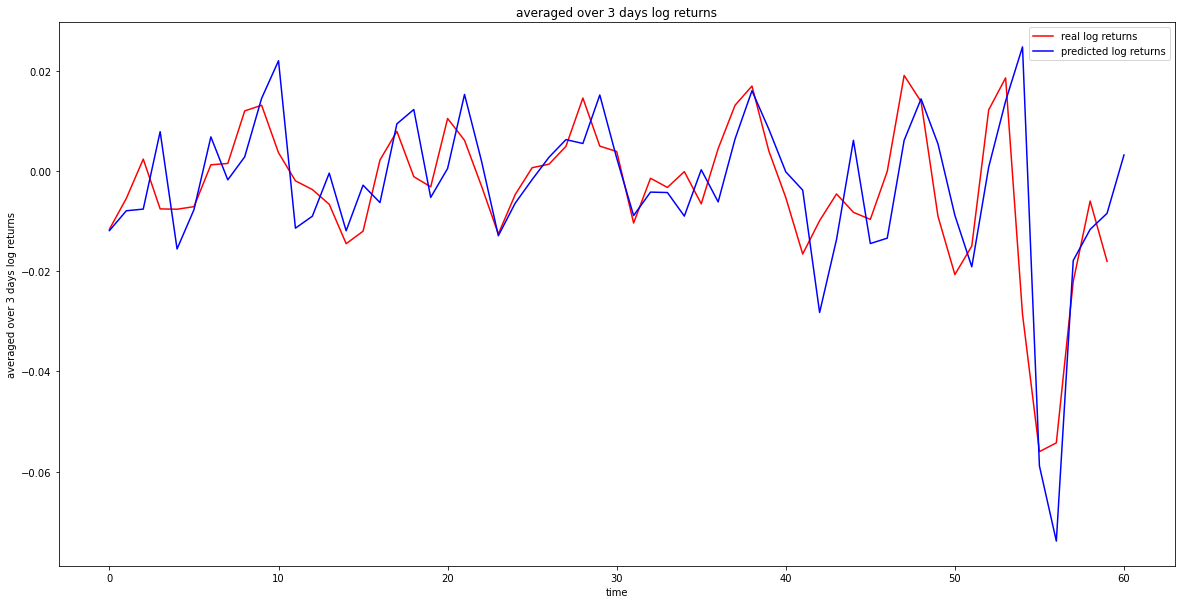

In [190]:
#visualize results
plt.figure(figsize=(20,10))
plt.plot(real[:], color='red', label='real log returns')
plt.plot(predicted[:], color='blue', label='predicted log returns')
plt.title('averaged over 3 days log returns')
plt.xlabel('time')
plt.ylabel('averaged over 3 days log returns')
plt.legend()
plt.show()

The question arises: would the predictions get even better if the test data were smoother? The graph shows that if you construct a 'smoothed' dataset $$r_t = \frac{x_t + x_{t+1}}{2}$$ the prediction is actually worse. We conclude that the trained RNN picks up the specific structure of a dataset it was trained on, and makes predictions based on that structure.

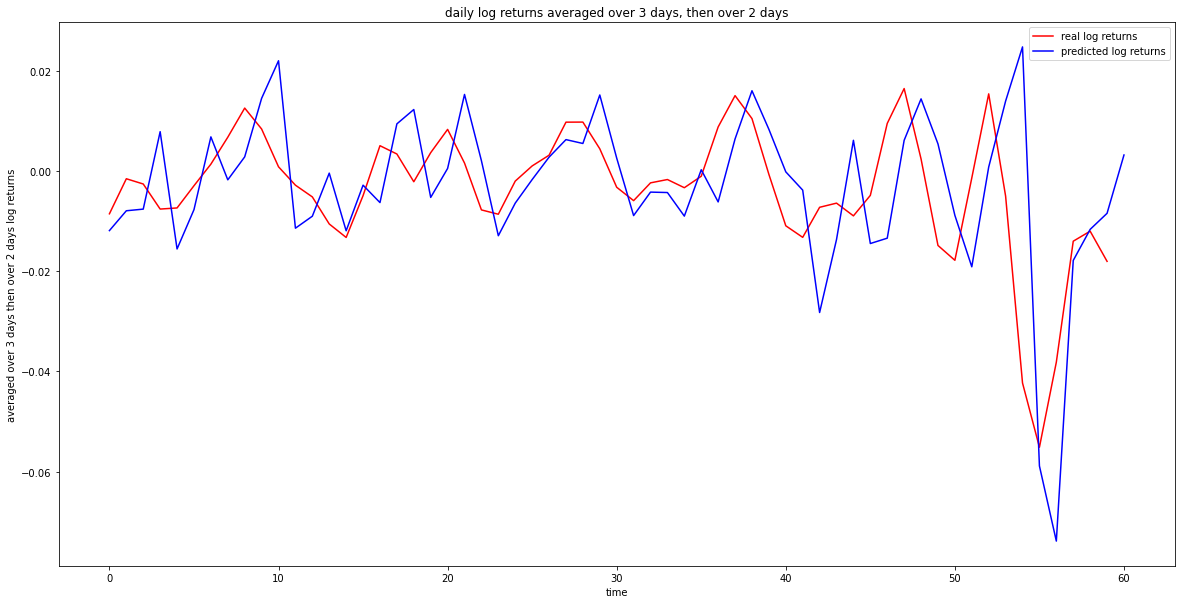

In [192]:
#visualize results
r = []
for i in range(2,len(real)+2):
    r.append(np.array(real[i-2:i]).mean())
#print(r)
plt.figure(figsize=(20,10))
plt.plot(r[:], color='red', label='real log returns')
plt.plot(predicted[:], color='blue', label='predicted log returns')
plt.title('daily log returns averaged over 3 days, then over 2 days')
plt.xlabel('time')
plt.ylabel('averaged over 3 days then over 2 days log returns')
plt.legend()
plt.show()

Conclusions:  if a sufficiently large and complex LSTM neural network is trained to predict the moving average of log returns of stock prices with the window width 3, the predictions are very accurate, showing that the RNN can actually learn the pattern rather than regard it as random. This requires very long training times and the results improve significantly with the larger number of epochs.